In [2]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
#from multiprocess import Pool


import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [4]:
def read_files(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"]}

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [39]:
cool, heat = {
    "q": 3,
    "L": 16,
    "D": 1.99,
    "R" : 32768,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}, {
    "q": 3,
    "L": 16,
    "D": 1.99,
    "R" : 32768,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}

for parameters in [cool, heat]:
    parameters = read_files(parameters)

/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_73084/167725292.py:7: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])
/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_73084/167725292.py:16: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])


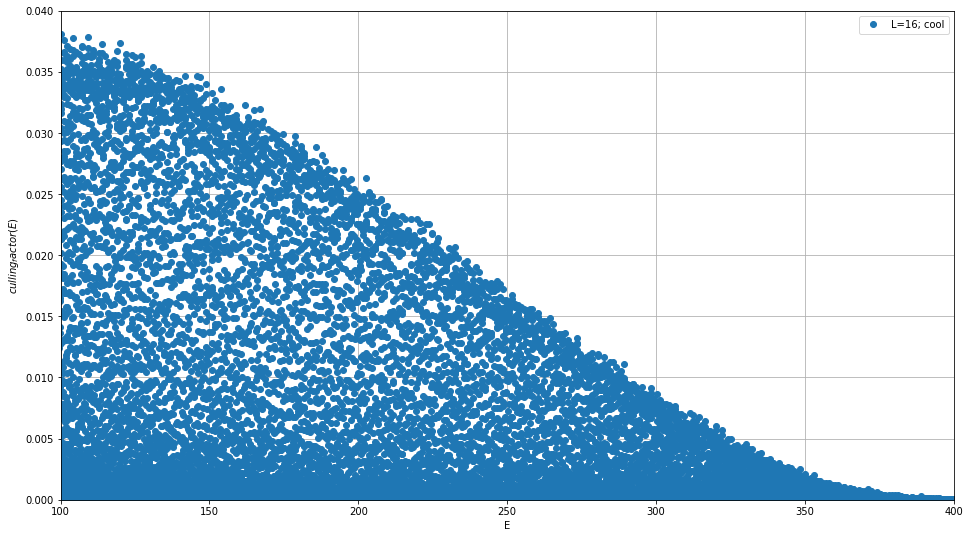

In [40]:
plt.figure(figsize=(16, 9))

#for L in lst:
    
plt.plot([E for E in cool["culling_factor"]], [S for E, S in cool["culling_factor"].items()]
         , 'o', label="L={}; cool".format(cool["L"]))

plt.ylabel("$culling_factor(E)$")
plt.xlabel("E")
plt.ylim([0, 0.04])
plt.xlim([100, 400])
plt.legend()
plt.grid()

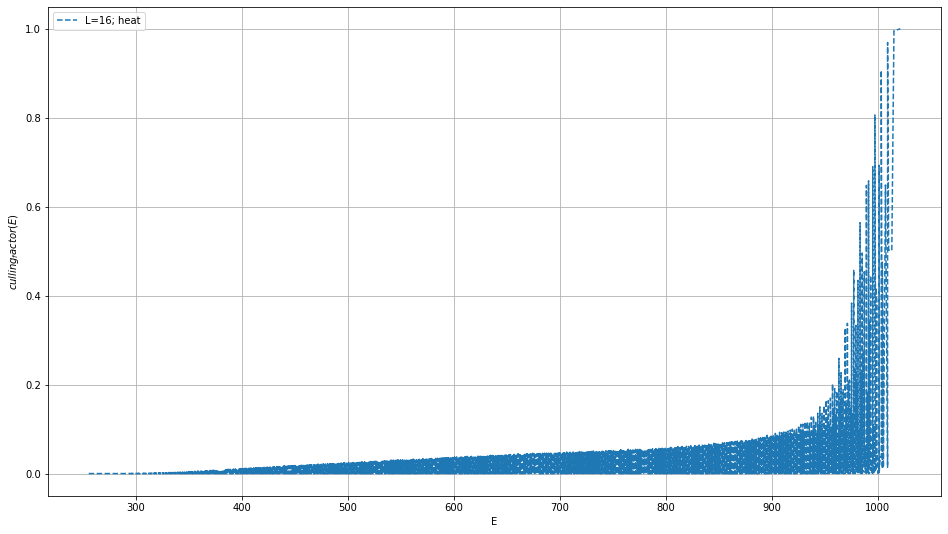

In [41]:
plt.figure(figsize=(16, 9))

#for L in lst:
    
plt.plot([E for E in heat["culling_factor"]], [S for E, S in heat["culling_factor"].items()]
         , '--', label="L={}; heat".format(heat["L"]))

plt.ylabel("$culling_factor(E)$")
plt.xlabel("E")
#plt.ylim([-200, -175])
#plt.xlim([-216, -175])
plt.legend()
plt.grid()

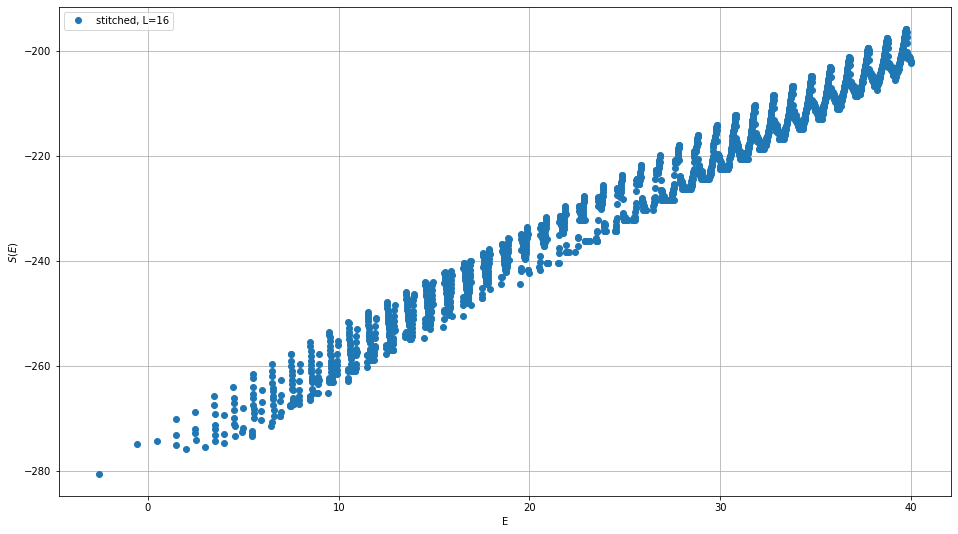

In [45]:
plt.figure(figsize=(16, 9))

st = stitch_S(heat, cool);

plt.plot([E for E, S in st["S"].items() if E < 40],
         [S for E, S in st["S"].items() if E < 40]
         , 'o', label="stitched, L={}".format(st["L"]))

#plt.ylabel("$g = e^{S(E)}$")
plt.ylabel("$S(E)$")
plt.xlabel("E")
#left
#plt.ylim([-1150, -1050])
#plt.xlim([-2060, -2000])
#middle
#plt.ylim([-100, 10])
#plt.xlim([-900, -500])
#right
#plt.ylim([-800, -200])
#plt.xlim([-100, 10])

plt.legend()
plt.grid()

In [37]:
h = {
    "q": 3,
    "L": 16,
    "D": 1.99,
    "R" : 32768,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}

q=h["q"];
L=h["L"];
R=h["R"];
D=h["D"];
nSteps=h["nSteps"];
seed=h["seed"];
heat=h["heat"];
N = L * L;
i = 0
name = "./datasets/hysteresis/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
#print(name)
culling_factor_0 = od()
culling_factor_1 = od()
culling_factor_2 = od()
#print(N, R, nSteps, heat)
with open(name) as f:
    iter_s = iter(f)
    for line in iter_s:
        try:
            E, c = map(float, line.split())
            culling_factor_0[E] = c
        except:
            break;

    for line in iter_s:
        if line[:10] == 'Hysteresis':
            line = next(iter_s)
        try:
            E, c = map(float, line.split())
            culling_factor_1[E] = c
        except:
            break;

    for line in iter_s:
        if line[:10] == 'Hysteresis':
            line = next(iter_s)
        try:
            E, c = map(float, line.split())
            culling_factor_2[E] = c
        except:
            break;
S_0 = get_entropy_from_culling_factor_v2(culling_factor_0)
S_1 = get_entropy_from_culling_factor_with_heat_v2(culling_factor_1)
S_2 = get_entropy_from_culling_factor_v2(culling_factor_2)

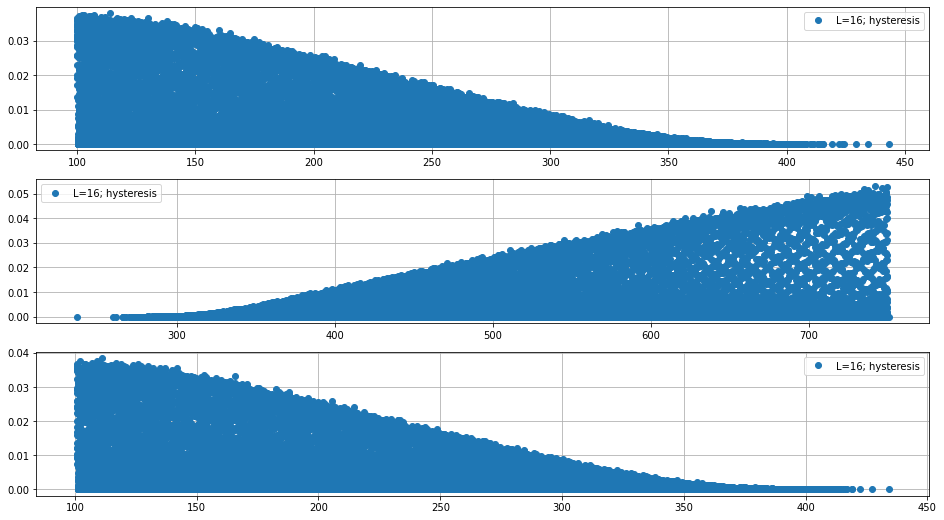

In [18]:
plt.figure(figsize=(16, 9))
plt.subplot(3,1,1)
plt.plot([E for E in culling_factor_0], [S for E, S in culling_factor_0.items()]
         , 'o', label="L={}; hysteresis".format(h["L"]))
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot([E for E in culling_factor_1], [S for E, S in culling_factor_1.items()]
         , 'o', label="L={}; hysteresis".format(h["L"]))
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot([E for E in culling_factor_2], [S for E, S in culling_factor_2.items()]
         , 'o', label="L={}; hysteresis".format(h["L"]))
plt.legend()
plt.grid()

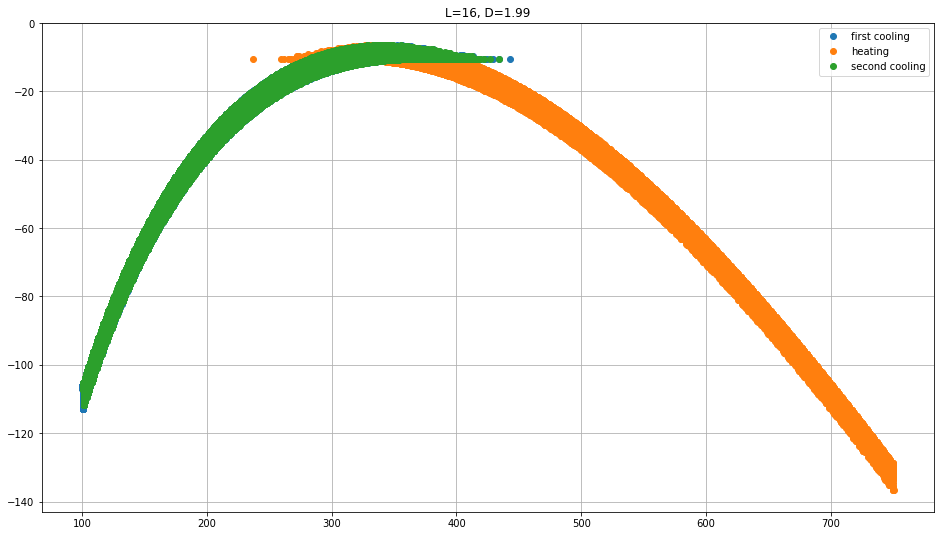

In [28]:
plt.figure(figsize=(16, 9))

plt.plot([E for E in S_0], [S for E, S in S_0.items()]
         , 'o', label="first cooling".format(h["L"]))
plt.plot([E for E in S_1], [S for E, S in S_1.items()]
         , 'o', label="heating".format(h["L"]))
plt.plot([E for E in S_2], [S for E, S in S_2.items()]
         , 'o', label="second cooling".format(h["L"]))
plt.title('L={}, D={}'.format(L, D))
plt.legend(
plt.grid()

(-120.0, -80.0)

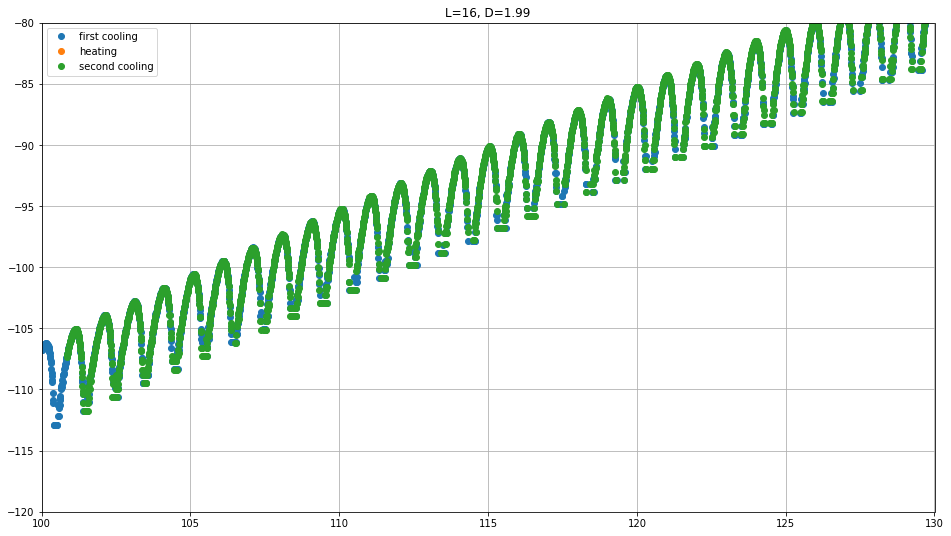

In [30]:
plt.figure(figsize=(16, 9))

plt.plot([E for E in S_0], [S for E, S in S_0.items()]
         , 'o', label="first cooling".format(h["L"]))
plt.plot([E for E in S_1], [S for E, S in S_1.items()]
         , 'o', label="heating".format(h["L"]))
plt.plot([E for E in S_2], [S for E, S in S_2.items()]
         , 'o', label="second cooling".format(h["L"]))
plt.title('L={}, D={}'.format(L, D))

plt.legend()
plt.grid()

plt.xlim([100, 130])
plt.ylim([-120, -80])